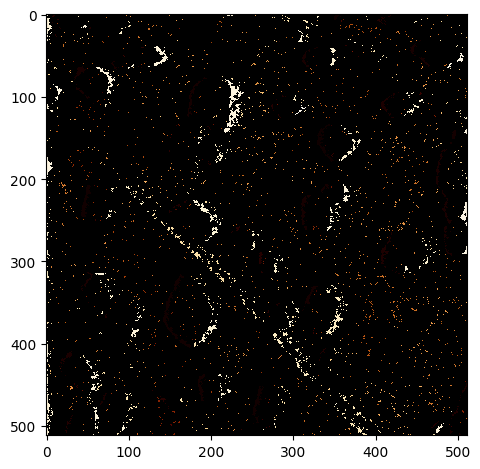

In [ ]:
from skimage import io, segmentation, color
from skimage.future import graph
import numpy as np

def _weight_mean_color(graph, src, dst, n):
    """Callback to handle merging nodes by recomputing mean color.

    Parameters
    ----------
    graph : RAG
        The graph under consideration.
    src, dst : int
        The vertices in `graph` to be merged.
    n : int
        A neighbor of `src` or `dst` or both.

    Returns
    -------
    data : dict
        A dictionary with the `"weight"` attribute set as the absolute
        difference of the mean color between node `dst` and `n`.
    """
    diff = graph.nodes[dst]['mean color'] - graph.nodes[n]['mean color']
    diff = np.linalg.norm(diff)
    return {'weight': diff}

def merge_mean_color(graph, src, dst):
    """Callback called before merging two nodes of a mean color distance graph.

    Parameters
    ----------
    graph : RAG
        The graph under consideration.
    src, dst : int
        The vertices in `graph` to be merged.
    """
    graph.nodes[dst]['total color'] += graph.nodes[src]['total color']
    graph.nodes[dst]['pixel count'] += graph.nodes[src]['pixel count']
    graph.nodes[dst]['mean color'] = (
        graph.nodes[dst]['total color'] / graph.nodes[dst]['pixel count']
    )

def process_image(image_path):
    # Load the image from the given path
    img = io.imread(image_path)

    # Apply SLIC algorithm to segment the image
    labels = segmentation.slic(img, compactness=30, n_segments=1000000, start_label=1)

    # Create a Region Adjacency Graph (RAG) based on the mean color of the regions
    g = graph.rag_mean_color(img, labels)

    # Merge regions hierarchically based on mean color
    labels2 = graph.merge_hierarchical(
        labels,
        g,
        thresh=35,
        rag_copy=False,
        in_place_merge=True,
        merge_func=merge_mean_color,
        weight_func=_weight_mean_color,
    )

    # Create an output image where the segmented regions are colored with their mean color
    out = color.label2rgb(labels2, img, kind='avg', bg_label=0)
    out = segmentation.mark_boundaries(out, labels2, (0, 0, 0))

    # Display the result
    io.imshow(out)
    io.show()

# Example usage: Replace 'path_to_your_image.jpg' with the path to your image
image_path = '/content/11_amplitude.jpg'  # Update this path
process_image(image_path)
